In [1]:
import numpy as np
from numpy import random
from numpy.random import randn
from numpy.fft import fft2, ifft2

from scipy.special import gamma
from scipy.interpolate import griddata
import scipy.constants as sc

from numba import jit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import animation

In [2]:
cn2 = 1e-14
PropDist = 3000.0
beam_waist = 0.05
wavelength = 1e-06
f_curv = -3000.0
log2Nrange_list = [9, 8]

In [3]:
class Source(object):
    
    def PlaneSource(self):
        
        "Uniform Plane Wave"

        self.plane = np.ones([self.N,self.N]) 

        return self.plane
    
    def PointSourceF(self):

        "As defined by S.M. Flatte"
        
        self.fpoint = np.exp(-(self.r1 ** 2) / (10 * (self.dx ** 2))) \
              * np.cos(-(self.r1 ** 2) / (10 * (self.dx ** 2)))
        return self.fpoint
    
    def PointSourceS(self):
        
        "Traditional Point Source"
        
        DROI = 4.0 * self.DRx  # Observation plane region [m]
        D1 = self.wvl * self.PropDist / DROI  # Central Lobe width [m]
        R = self.PropDist  # Radius of curvature at wavefront [m
        temp = np.exp(-1j * self.k / (2 * R) * (self.r1 ** 2)) / (D1 ** 2)
        self.spoint = temp * np.sinc((self.x1 / D1)) * \
                    np.sinc((self.y1 / D1)) * np.exp(-(self.r1 / (4.0 * D1)) ** 2)

        return self.spoint
    
    def SuperGaussBound(self):
        
        "Construct Super Gaussian Boundary"

        # Construction of Super Gaussian Boundary
        self.radian = self.r1 * (self.N);
        self.width = 0.55 * self.N
        self.sgb = np.exp(- ((self.radian / self.width) ** 16.0))

        return self.sgb

In [4]:
class Observer(object):
    
    def PupilMask(self, D_eval):
        
        # Target pupil creation
        self.boundary1 = -(self.SideLen / 2)  # sets negative coord of sidelength
        self.boundary2 = self.SideLen / 2  # sets positive coord of sidelength

        A = np.linspace(self.boundary1, self.boundary2, self.N)  # creates a series of numbers evenly spaced between
        # positive and negative boundary
        A = np.array([A] * self.N)  # horizontal distance map created

        base = np.linspace(self.boundary1, self.boundary2, self.N)  # creates another linspace of numbers
        set_ones = np.ones(self.N)  # builds array of length N filled with ones
        B = np.array([set_ones] * self.N)
        for i in range(0, len(base)):
            B[i] = B[i] * base[i]  # vertical distance map created

        self.A = A.reshape(self.N, self.N)
        self.B = B.reshape(self.N, self.N)  # arrays reshaped into matrices

        x_coord = self.A ** 2
        y_coord = self.B ** 2

        self.rad_dist = np.sqrt(x_coord + y_coord)  # now radial distance has been defined

        mask = []
        for row in self.rad_dist:
            for val in row:
                if val < D_eval:
                    mask.append(1.0)
                elif val > D_eval:
                    mask.append(0.0)
                elif val == D_eval:
                    mask.append(0.5)
        mask = np.array([mask])
        self.mask = mask.reshape(self.N, self.N)  # mask created and reshaped into a matrix

        return self.mask  # returns the pupil mask as the whole function's output

In [5]:
class Screen(object):
    
    def Kolmogorov(self, delta):
        
        "Phase screen with Kolmogorov turbulence statistics"
        
        self.del_f = 1.0 / (self.N * delta)  # Define frequency sampling at the current plane        
        self.cen = np.floor(self.N / 2) # Define zero-frequency center of the phase screen
        
        # Create frequency sample grid
        self.fx = np.arange(-self.N / 2.0, self.N / 2.0) * self.del_f
        self.fx, self.fy = np.meshgrid(self.fx, -1 * self.fx)
        self.tx = self.fx * np.cos(self.thetar) + self.fy * np.sin(self.thetar) # Apply affine transform in x
        self.ty = -1.0 * self.fx * np.sin(self.thetar) + self.fy * np.cos(self.thetar) # Apply affine transform in y
        self.f = np.sqrt((self.tx ** 2.0) / (self.b ** 2.0) + (self.ty ** 2.0) / (self.c ** 2.0)) # Scalar frequency grid
        
        # Sample Turbulence PSD
        self.PSD_phi = (self.cone * self.Bfac * ((self.b * self.c) ** \
                    (-self.na / 2.0)) * (self.r0scrn ** (2.0 - self.na)) 
                        * np.exp(-(self.f / self.l0_freq) ** 2.0) \
                   / ((self.f ** 2.0 + self.f0 ** 2.0) ** (self.na / 2.0))) 
        self.tot_NOK = np.sum(self.PSD_phi)
        self.PSD_phie = (self.conee * self.Bface * (self.r0scrn ** \
                    (2.0 - self.norm_alpha)) * np.exp(-(self.f / self.fme) ** 2.0) \
                    / ((self.f ** 2.0 + self.f0 ** 2.0) ** (self.norm_alpha / 2.0))) # Kolmogorov equivalent and enforce isotropy
        self.tot_OK = np.sum(self.PSD_phie)
        self.PSD_phi = (self.tot_OK / self.tot_NOK) * self.PSD_phi
        self.PSD_phi[np.int(self.cen), np.int(self.cen)] = 0.0 # Kolmogorov PSD (PSD_phi = cone*Bfac* (r0**(2-na)) * f**(-na/2))
        cn = (np.random.randn(self.N, self.N) + 1j * np.random.randn(self.N, self.N)) # Create a random field that is circular complex Guassian
        self.cn = cn * np.sqrt(self.PSD_phi) * self.del_f # Filter by turbulence PSD
        self.phz_temp = np.fft.ifft2(np.fft.fftshift(self.cn)) * ((self.N) ** 2) # Inverse FFT
        
        # Phase screens
        phz1 = np.real(self.phz_temp)
        self.phz1 = phz1
        
        return self.phz1
    
    def StructureFunc(self, phasescreen):

        # Define mask construction
        self.mask = Observer.PupilMask(self, self.SideLen / 4)
        self.delta = self.SideLen / self.N

        self.N_size = np.shape(phasescreen)  # Make sure to reference 0th element later
        phasescreen = phasescreen * self.mask

        self.P = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(phasescreen))) * (self.delta ** 2)
        self.S = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(phasescreen ** 2))) * (self.delta ** 2)
        self.W = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(self.mask))) * (self.delta ** 2)
        self.delta_f = 1 / (self.N_size[0] * self.delta)

        self.fft_size_a = np.shape(self.W * np.conjugate(self.W))
        self.w2 = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(self.W * np.conjugate(self.W)))) * ((self.fft_size_a[0] * self.delta_f) ** 2)

        self.fft_size_b = np.shape(np.real(self.S * np.conjugate(self.W)) - np.abs(self.P) ** 2)
        D = 2 * ((np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(np.real(self.S * \
                        np.conjugate(self.W)) - np.abs(self.P) ** 2)))) * ((self.fft_size_b[0] * self.delta_f) ** 2))

        D = D / self.w2

        self.D = np.abs(D) * self.mask

        return self.D


In [6]:
class Propagator(object):
    
    def SplitStep(self, Uin, PhaseScreenStack):
        
        "Propagation with Kirchhoff (or Fresnel) Diffraction Integral"
        
        sgb = self.SuperGaussBound()  # Generates Super Gaussian Boundary

        SamplingRatio = self.SamplingRatioBetweenScreen

        a = int(self.N / 2)

        nx, ny = np.meshgrid(range(-a, a), range(-a, a))

        # Initial Propagation from source plane to first screen location
        P0 = np.exp(1j * (self.k / (2 * self.dzProps[0])) * (self.r1 ** 2) * (1 - SamplingRatio[0]))

        Uin = P0 * Source.PlaneSource(self) * np.exp(1j * PhaseScreenStack[:, :, 0])

        for pcount in range(1, len(self.PropLocs) - 2):
            UinSpec = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))

            # Set spatial frequencies at propagation plane
            deltaf = 1 / (self.N * self.PropSampling[pcount])
            fX = nx * deltaf
            fY = ny * deltaf
            fsq = fX ** 2 + fY ** 2

            # Quadratic Phase Factor
            QuadPhaseFac = np.exp(-1j * np.pi * self.wvl * self.dzProps[pcount] \
                                  * SamplingRatio[pcount] * fsq)

            Uin = np.fft.ifftshift(np.fft.ifft2( \
                np.fft.ifftshift(UinSpec * QuadPhaseFac)))

            Uin = Uin * sgb * np.exp(1j * PhaseScreenStack[:, :, pcount - 1])

        PF = np.exp(1j * (self.k / (2 * self.dzProps[-1])) * (self.rR ** 2) * (SamplingRatio[-1]))

        Uout = PF * Uin

        return Uout
    
    
    def TurbSim(self):
        """
        Perform a turbulence simulation that accounts for the changing sampling planes over the course of the propagation
        through the atmosphere

        :return:
        """
        # initialize phase screen array
        phz = np.zeros(shape=(self.N, self.N, self.NumScr))
        phz_lo = np.zeros(shape=(self.N, self.N, self.NumScr))
        phz_hi = np.zeros(shape=(self.N, self.N, self.NumScr))
        outputs = np.zeros(shape=(self.N, self.N, self.NumScr), dtype = 'complex128')

        for idxscr in range(0, self.NumScr, 1):

            # Retrieve the current sampling at the current propagation distance
            deltax_dz = self.PropSampling[idxscr]

            phz_hi[:, :, idxscr] = Screen.Kolmogorov(self, deltax_dz)
            # FFT-based phase screens

            #phz_lo[:, :, idxscr] = self.SubHarmonicComp(self.NumSubHarmonics,  deltax_dz)
            # sub harmonics
            #phz[:, :, idxscr] = self.loon * phz_lo[:, :, idxscr] + phz_hi[:, :, idxscr]
            phz[:, :, idxscr] = phz_hi[:, :, idxscr]
            # subharmonic compensated phase screens
            outputs[:, :, idxscr] = self.SplitStep(self.Source, np.exp(1j * phz))
            
        # Simulating propagation
        self.Output = self.SplitStep(self.Source, np.exp(1j * phz))
        
        return phz, outputs, self.Output

In [7]:
class Scattering(object):
    
    def Rytov(self, Rytovnum):
        # Change rytov number and variance to user specified value
        self.rytovNum = Rytovnum
        self.rytov = self.rytovNum ** 2

        rytov_denom = 1.23 * (self.k) ** (7.0 / 6.0) * (self.PropDist) ** (11.0 / 6.0)

        # Find Cn2
        self.Cn2 = self.rytov / rytov_denom
        
        phase_var = np.zeros((100))
        log_ampl_var = np.zeros((100))
        r0 = np.zeros((100))
        rho_0 = np.zeros((100))
        
        range_steps = [r for r in np.arange(0, self.PropDist, self.PropDist//100)]
        for d in range(100):
            log_ampl_var[d] = 0.3075 * ((self.k) ** 2) * ((range_steps[d]) ** (11.0 / 6.0)) * self.Cn2
            phase_var[d] = 0.78 * (self.Cn2) * (self.k ** 2) * range_steps[d] * (self.L0 ** (-5.0 / 3.0))
            r0[d] = (0.423 * (self.k) ** 2 * self.Cn2 * range_steps[d]) ** (-3.0 / 5.0)
            rho_0[d] = (1.46 * self.Cn2 * self.k ** 2 * range_steps[d]) ** (-5.0 / 3.0)
        self.log_ampl_var = log_ampl_var
        self.phase_var = phase_var
        self.r0 = r0
        self.rho_0 = rho_0
        # Set derived values
        #self.r0 = (0.423 * (self.k) ** 2 * self.Cn2 * self.PropDist) ** (-3.0 / 5.0)
        self.r0scrn = (0.423 * ((self.k) ** 2) * self.Cn2 * (self.PropDist / self.NumScr)) ** (-3.0 / 5.0)
        #self.log_ampl_var = 0.3075 * ((self.k) ** 2) * ((self.PropDist) ** (11.0 / 6.0)) * self.Cn2
        #self.phase_var = 0.78 * (self.Cn2) * (self.k ** 2) * self.PropDist * (self.L0 ** (-5.0 / 3.0))
        #self.rho_0 = (1.46 * self.Cn2 * self.k ** 2 * self.PropDist) ** (-5.0 / 3.0)
        
        return self.r0, self.r0scrn, self.log_ampl_var, self.phase_var, self.rho_0

In [8]:
class BranchFlow(Source, Screen, Propagator, Scattering):
    
    def __init__(self, simOption=0, N=256, SideLen=1.0, NumScr=30, DRx=10, dx=5e-3,
                 wvl=1e-6, PropDist=10e1, Cn2=1e-10, loon=1, aniso=1.0, Rdx=5e-3, f_curv = -10e3,
                 L0 = 1e3, W0 = 5e-2):
        
        self.N = N  # number of grid points per side
        self.SideLen = SideLen  # Length of one side of square phase secreen [m]
        self.dx = dx  # Sampling interval at source plane
        self.Rdx = Rdx  # Sampling interval at receiver plane
        self.L0 = L0  # Turbulence outer scale [m]
        self.l0 = 100e3  # Turbulence inner scale [m]
        self.NumScr = NumScr  # Number of screens Turn into input variable
        self.DRx = DRx  # Diameter of aperture [m]
        self.wvl = wvl  # Wavelength [m]
        self.PropDist = PropDist  # Propagation distance(Path Length) [m]
        self.Cn2 = Cn2
        #self.simOption = simOption  # Simulation type (i.e. spherical, plane)
        self.theta = 0  # Angle of anisotropy [deg]
        self.aniso = aniso  # Anisotropy magnitude
        self.axratio = np.abs(np.sin(self.theta)/np.cos(self.theta))
        print('Axial Ratio: ', self.axratio)
        self.alpha = 22.0  # Power Law exponent 22 = 11/3 (Kolmogorov)
        self.k = 2 * np.pi / self.wvl  # Optical wavenumber [rad/m]
        self.NumSubHarmonics = 5  # Number of subharmonics
        self.w0 = W0 # the gaussian width of the beam
        self.DTx = np.sqrt(2) * self.w0 #0.1  # Transmitting aperture size for Gauss, as defined by beam waist [m]
        self.fcurv = f_curv # the radius of curvature of the beam at the aperture of the source, negative is diverging
        #self.beam_rider_quadrant = beam_rider_quadrant # 1,2,3,4 denotes top, right, bottom, left, respectively
        
        # Include sub-harmonic compensation?
        self.loon = loon
        # Simulation output
        self.Output = np.zeros((N, N))

        # Place holders for geometry/source variables
        self.Source = None
        self.r1 = None
        self.x1 = None
        self.y1 = None
        self.rR = None
        self.xR = None
        self.yR = None
        self.Uout = None

        x = np.linspace(-self.N / 2, (self.N / 2) - 1, self.N) * self.dx
        y = np.linspace(-self.N / 2, (self.N / 2) - 1, self.N) * self.dx
        self.x1, self.y1 = np.meshgrid(x, y)
        self.r1 = np.sqrt(self.x1 ** 2 + self.y1 ** 2)
        
        # Screen Constants
        self.b = self.aniso
        self.c = 1.0
        self.thetar = (np.pi / 180.0) * self.theta
        self.na = self.alpha / 6.0  # Normalized alpha value
        self.Bnum = gamma(self.na / 2.0)
        self.Bdenom = 2.0 ** (2.0 - self.na) * np.pi * self.na * gamma(-self.na / 2.0)
        self.cone = (2.0 * (8.0 / (self.na - 2.0) * gamma(2.0 / (self.na - 2.0))) ** \
                ((self.na - 2.0) / 2.0)) # c1 Striblings Consistency parameter. (6.88 - KolTurb)
        self.Bfac = (2.0 * np.pi) ** (2.0 - self.na) * (self.Bnum / self.Bdenom) # Charnotskii/Bos generalized phase consistency parameter
        self.a = gamma(self.na - 1.0) * np.cos(self.na * np.pi / 2.0) / (4.0 * np.pi ** 2.0)
        self.c_a = (gamma(0.5 * (5.0 - self.na)) * self.a * 2.0 * np.pi / 3.0) \
                    ** (1.0 / (self.na - 5.0)) # Toselli's inner-scale intertial range consistency parameter
        self.l0_freq = self.c_a / self.l0  # Inner scale frequency(1/m)
        
        # Set up parameters for Kolmogorov PSD
        self.norm_alpha = 22 / 6.0  # Normalized alpha value
        self.B_numerator = gamma(self.norm_alpha / 2.0)
        self.B_denomenator = 2.0 ** (2.0 - self.norm_alpha) * np.pi * self.norm_alpha * gamma(-self.norm_alpha / 2.0)
        self.conee = (2.0 * (8.0 / (self.norm_alpha - 2.0) * gamma(2.0 / (self.norm_alpha - 2.0))) ** ((self.norm_alpha - 2.0) / 2.0))
        self.Bface = (2.0 * np.pi) ** (2.0 - self.norm_alpha) * (self.B_numerator / self.B_denomenator)
        self.alpha = gamma(self.norm_alpha - 1.0) * np.cos(self.norm_alpha * np.pi / 2.0) / (4.0 * np.pi ** 2.0)
        self.c_alpha = (gamma(0.5 * (5.0 - self.norm_alpha)) * self.alpha * 2.0 * np.pi / 3.0) ** (1.0 / (self.norm_alpha - 5.0))
        self.fme = self.c_alpha / self.l0  # Inner scale frequency(1/m)
        self.f0 = 1.0 / self.L0  # Outer scale frequency
        
        #-----------------------------------------------------------------------------
        
        x = np.linspace(-self.N / 2, (self.N / 2) - 1, self.N) * self.Rdx
        y = np.linspace(-self.N / 2, (self.N / 2) - 1, self.N) * self.Rdx
        self.xR, self.yR = np.meshgrid(x, y)
        self.rR = np.sqrt(self.xR ** 2 + self.yR ** 2)

        # Set Propagation Geometry / Screen placement
        self.dzProps = np.ones(self.NumScr + 2) * (self.PropDist / self.NumScr)
        self.dzProps[0:2] = 0.5 * (self.PropDist / self.NumScr)
        self.dzProps[self.NumScr:self.NumScr + 2] = 0.5 * (self.PropDist / self.NumScr)
        self.PropLocs = np.zeros(self.NumScr + 3)

        for zval in range(0, self.NumScr + 2):
            self.PropLocs[zval + 1] = self.PropLocs[zval] + self.dzProps[zval]

        self.ScrnLoc = np.concatenate((self.PropLocs[1:self.NumScr],
                                       np.array([self.PropLocs[self.NumScr + 1]])), axis=0)

        self.FracPropDist = self.PropLocs / self.PropDist

        self.PropSampling = (self.Rdx - self.dx) * self.FracPropDist + self.dx

        self.SamplingRatioBetweenScreen = \
            self.PropSampling[1:len(self.PropSampling)] \
            / self.PropSampling[0:len(self.PropSampling) - 1]

        # Set derived values
        self.r0 = (0.423 * (self.k) ** 2 * self.Cn2 * self.PropDist) ** (-3.0 / 5.0)
        self.r0scrn = (0.423 * ((self.k) ** 2) * self.Cn2 * (self.PropDist / self.NumScr)) ** (-3.0 / 5.0)
        self.log_ampl_var = 0.3075 * ((self.k) ** 2) * ((self.PropDist) ** (11.0 / 6.0)) * self.Cn2
        self.phase_var = 0.78 * (self.Cn2) * (self.k ** 2) * self.PropDist * (self.L0 ** (-5.0 / 3.0))
        self.rho_0 = (1.46 * self.Cn2 * self.k ** 2 * self.PropDist) ** (-5.0 / 3.0)
        self.rytovNum = np.sqrt(1.23 * self.Cn2 * (self.k ** (7 / 6)) * (self.PropDist ** (11 / 6)))
        self.rytovVar = self.rytovNum ** 2
        
    def Simulate(self):    

        scr = Screen.Kolmogorov(self, 1) 
        strfunc = Screen.StructureFunc(self, scr)
        prop = Propagator.TurbSim(self)
        # Note: Rytov number > 0.2 is generally considered strong scintillation,
        # whereas 0 is no turbulence/no scintillation of the beam.
        scat = Scattering.Rytov(self, 0.2)
        return scr, strfunc, prop, scat

In [9]:
scr, strfunc, prop, scat = BranchFlow().Simulate()
# Unpack the variables
phstack, outs, out = prop
r0, r0scrn, log_ampl_var, phase_var, rho0 = scat

Axial Ratio:  0.0


<ipython-input-7-625d1af3f7a4>:22: RuntimeWarning: divide by zero encountered in double_scalars
  r0[d] = (0.423 * (self.k) ** 2 * self.Cn2 * range_steps[d]) ** (-3.0 / 5.0)
<ipython-input-7-625d1af3f7a4>:23: RuntimeWarning: divide by zero encountered in double_scalars
  rho_0[d] = (1.46 * self.Cn2 * self.k ** 2 * range_steps[d]) ** (-5.0 / 3.0)


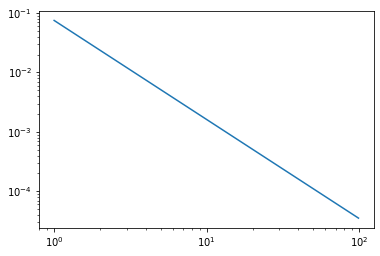

In [10]:
fig = plt.figure()
plt.loglog(rho0)
plt.show()

In [11]:
np.max(np.abs(outs[:, :, 9])**2)

1.0000000000126987

<IPython.core.display.Javascript object>


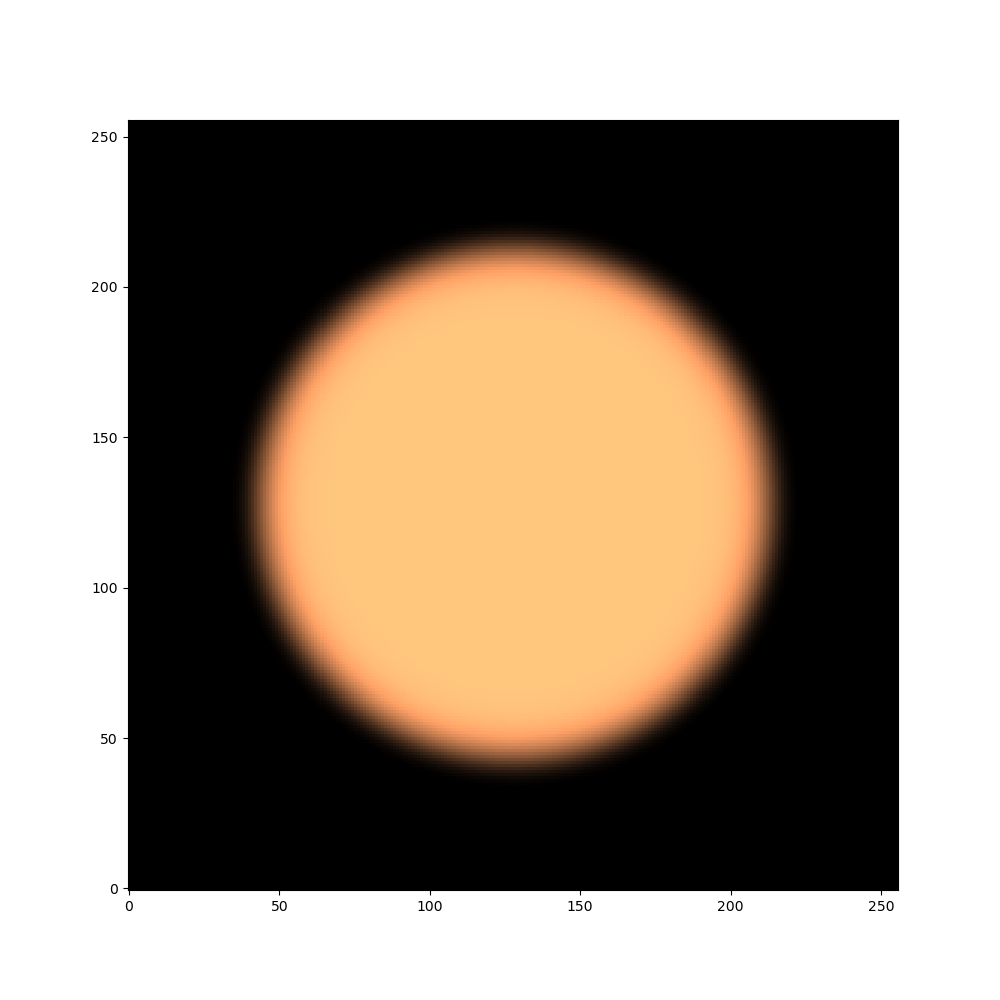

In [12]:
# Change matplotlib backend
%matplotlib notebook

#fig = plt.figure()

def beam_image(tstep):
    image = outs[:, :, tstep]
    return np.abs(image)**2

image = beam_image(0)

def init():
    global fig, ax, im
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes()
    im = ax.imshow(image, origin='lower', cmap=cm.copper)
    im.set_data(np.zeros(image.shape))
    return

def animate(tstep):
    image = beam_image(tstep)
    im.set_data(image)
    return

init()
anim = animation.FuncAnimation(fig, animate, frames = 50, interval=200, repeat = True)
fig.show()

In [546]:
x = [i for i in np.arange(0, 20, 20.2324//10)]
print(x)

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0]
